In [162]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb   #machine learning model based on random forest algorithm
from sklearn.metrics import mean_squared_error

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
df = pd.read_csv('Datasets/prc_Food_Germany_sorted.csv', sep=",", header=0)
df

,Datetime,FoodPriceIndex
0,1996-01,74.9
1,1996-02,75.5
2,1996-03,76.1
3,1996-04,76.4
4,1996-05,76.2
...,...,...
325,2023-02,145.6
326,2023-03,147.6
327,2023-04,146.5
328,2023-05,146.2


### Formatting Pipeline:
* Drop data before 1996
* Create a new column consisting of the year and month (format: YYYY-MM)
* Rename the Column "Deutschland" to "Temperature (°C)"
* Delete unnecassary columns
* Change the order

In [163]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataDropper(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X.drop(X[X["Jahr"]<1996].index)
        X.reset_index(drop=True)
        return X
    
    
class ColumnCreater(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X["Date"] = X["Jahr"].astype(str) + "-" + "0" + df["Monat"].astype(str)
        return X
    
    
class NameChanger(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        print('hello')
        X.rename(columns = {"Time":"Year"}, inplace=True)
        return X
    

class ColumnDropper(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        columns_to_delete = list(range(0,18))
        return X.drop(X.columns[columns_to_delete], axis=1)
    

class OrderChanger(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        new_columns_order = ["Date", "Temperature (°C)"]
        return X[new_columns_order]
    


   

### Data preprocessing:
- convert Datetime
- drop post 21
- plot data before preprocessing
- show outliers
- remove outliers
- remove trend by taking the differences between the values
- set Cross Validation Split
- create Features

In [164]:
class ConvertDateTime(BaseEstimator, TransformerMixin):

    def fit(self, X, y= None):
        return self
    
    def transform(self, X):
        print(type(X))
        X = X.set_index('Datetime')
        X.index = pd.to_datetime(X.index)
        return X

class DropPost21(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.loc[X.index < '2021-11']
        return X
    
class PlotPreData(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Foodprice index')
        plt.show
        return X

class ShowOutliers(BaseEstimator, TransformerMixin):

    def __init__(self,min,max):
        self.min = min
        self.max = max

    def fit(self, X, y= None):
        return self
    
    def transform(self, X):
        print(self.min)
        print(self.max)
        X['FoodPriceIndex'].plot(kind='hist',bins=500)
        print(X.query(f'FoodPriceIndex < {self.min}'))
        print(X.query(f'FoodPriceIndex > {self.max}'))
        return X

class RemoveOutliers(BaseEstimator, TransformerMixin):

    def __init__(self,min,max):
        self.min = min
        self.max = max

    def fit(self, X, y= None):
        return self
    
    def transform(self, X):
        X = X.query((f'FoodPriceIndex > {self.min}'))
        X = X.query((f'FoodPriceIndex < {self.max}'))
        X['FoodPriceIndex'].plot(kind='hist',bins=500)

        return X 
    

class AbsDiffData(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.diff()
        X = X.dropna()
        fig, ax = plt.subplots(figsize=(15,5))
        X.plot(ax=ax, label='Training Set', title='Difference between Data Points')
        ax.axvline('2015-01',color='black', ls='--')
        ax.legend(['Training Set', 'Test Set'])
        plt.show()
        return X

class CrossValidationSplit(BaseEstimator, TransformerMixin):

    def __init__(self,split_info, show_plot):
        self.split_info = split_info
        self.show_plot = show_plot

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):

        tss = self.split_info
        
        #sort dataset:
        X = X.sort_index()

        if self.show_plot:
            fig, axs = plt.subplots(tss.get_n_splits(), 1, figsize=(15,14), sharex=True)
        
        fold = 0

        #loop for aranging the split for the cross validation
        for train_idx, val_idx in tss.split(X):
            train = X.iloc[train_idx]
            test = X.iloc[val_idx]

            if self.show_plot:
                train['FoodPriceIndex'].plot(ax=axs[fold],label='Training Set',title=f'Data Train/Test Split Fold {fold}')
                test['FoodPriceIndex'].plot(ax=axs[fold],label='Test Set')
                axs[fold].axvline(test.index.min(), color='black', ls='--')
            fold += 1

        if self.show_plot: 
            plt.show()
        return X
    
class CreateFeatures(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        #Create time series features based on time series index
        X = X.copy()
        X['Month'] = X.index.month
        X['Year'] = X.index.year
        X['Quarter'] = X.index.quarter

        return X

### Model Training:

In [175]:
class TrainModel(BaseEstimator, TransformerMixin):
    
    def __init__(self,split_info,show_plot):
        self.split_info = split_info
        self.show_plot = show_plot

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):

        tss = self.split_info
        
        fold = 0
        preds = []
        scores = []
        for train_idx, val_idx in tss.split(X):
            train = X.iloc[train_idx]
            test = X.iloc[val_idx]
            print(train)
            #train = create_features(train)
            #test = create_features(test)

            FEATURES = ['Month','Year','Quarter']
            TARGET = 'FoodPriceIndex'

            X_train = train[FEATURES]
            y_train = train[TARGET]

            X_test = test[FEATURES]
            y_test = test[TARGET]

            reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                                n_estimators=1000,
                                early_stopping_rounds=50,
                                objective='reg:linear', #apparently deprecated for squarederror
                                max_depth=3,
                                learning_rate=0.01)
            reg.fit(X_train, y_train,
                    eval_set=[(X_train, y_train), (X_test, y_test)],
                    verbose=100)

           

            

        print('hallo for schleife :)')
        y_pred = reg.predict(X_test)
        preds.append(y_pred)
        score = np.sqrt(mean_squared_error(y_test, y_pred))
        scores.append(score)

        print(f'Score across folds (meansquarederror) {np.mean(scores):0.4f}')
        print(f'Fold scores:{scores}')
        
        #merge prediction and real data into one data frame
        test['prediction'] = reg.predict(X_test)
        X = X.merge(test[['prediction']], how='left', left_index=True, right_index=True)

        if self.show_plot:
                ax = X[['FoodPriceIndex']].plot(figsize=(15, 5))
                X['prediction'].plot(ax=ax, style='-')
                plt.legend(['Truth Data', 'Predictions'])
                ax.set_title('Raw Dat and Prediction')
                plt.show()

        return X

### Postprocessing:

In [ ]:
class ShowResults(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_pred = X.['prediction'].cumsum()
        X_train = X.loc[X.index < year]     #todo
        last_value = X_train.iloc[-1,0]
        X_pred = X_pred.add(last_value)
        X_merged = X- von ganz am Anfang (#todo)


        return X

<class 'pandas.core.frame.DataFrame'>


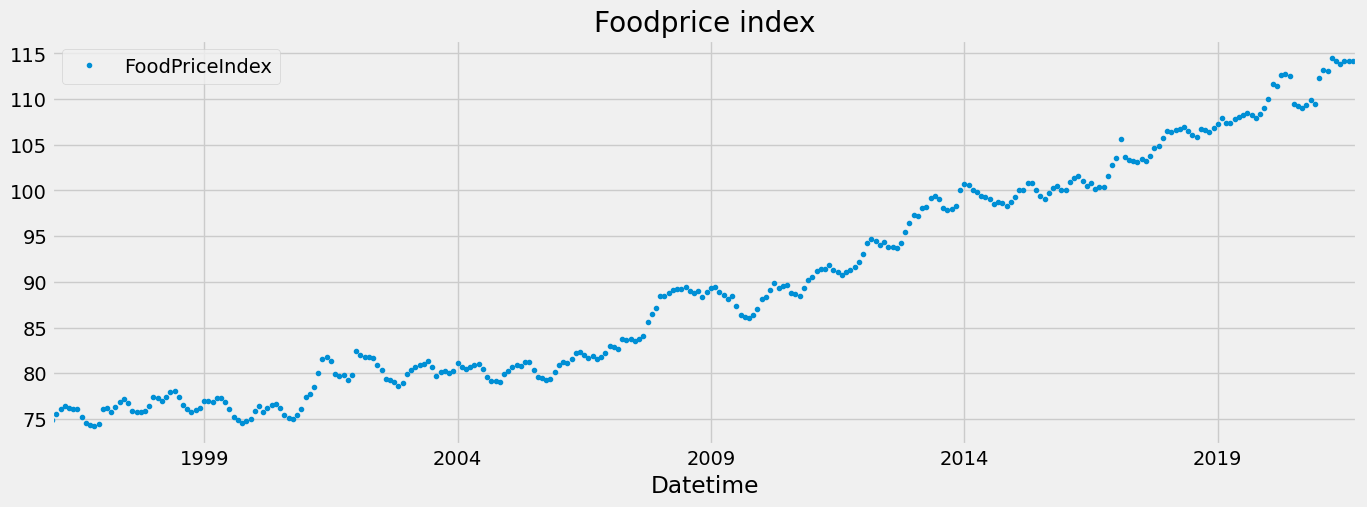

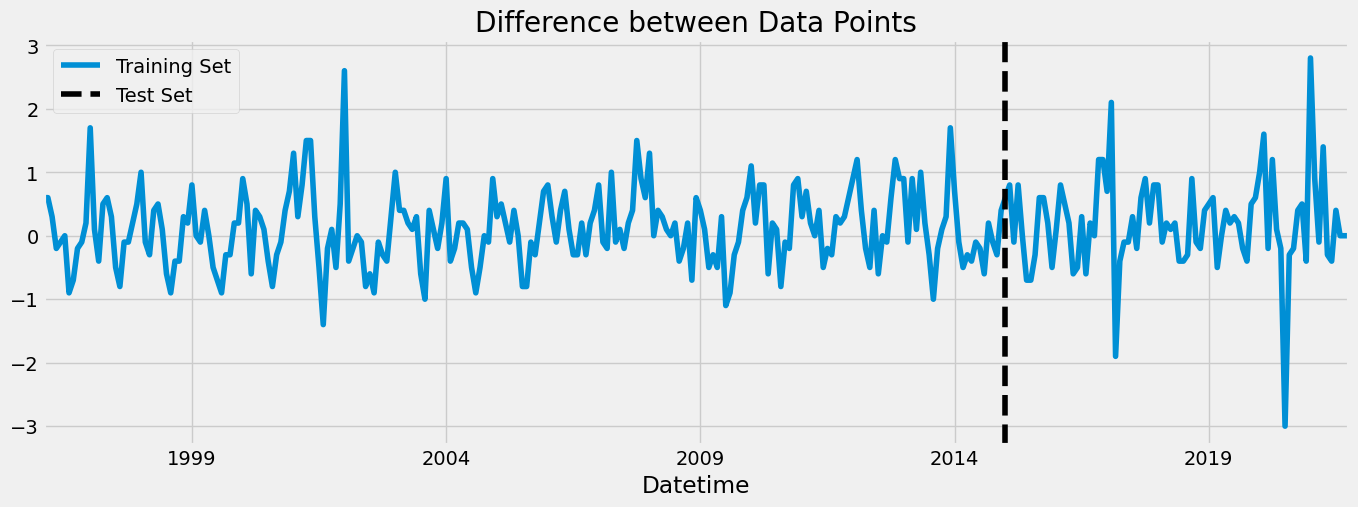

-1
2.5
            FoodPriceIndex
Datetime                  
2001-08-01            -1.4
2009-07-01            -1.1
2017-03-01            -1.9
2020-07-01            -3.0
            FoodPriceIndex
Datetime                  
2002-01-01             2.6
2021-01-01             2.8


,FoodPriceIndex
Datetime,
1996-02-01,0.6
1996-03-01,0.6
1996-04-01,0.3
1996-05-01,-0.2
1996-06-01,-0.1
...,...
2021-06-01,-0.4
2021-07-01,0.4
2021-08-01,0.0


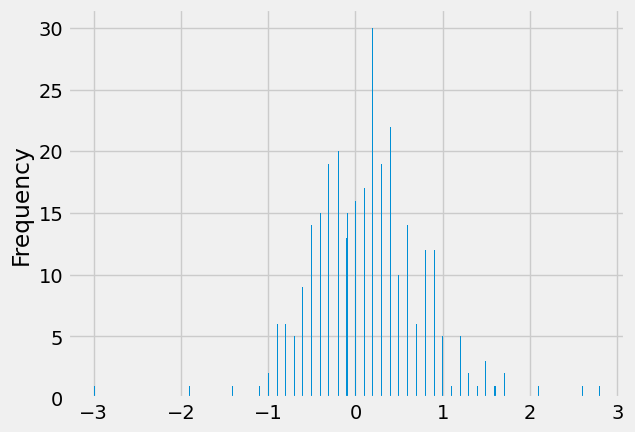

In [166]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ("1", ConvertDateTime()),
    ("2", DropPost21()),
    ("3", PlotPreData()),
    ("4", AbsDiffData()),
    ("5", ShowOutliers(-1,2.5))     #print values lower than (...,) and higher than (,...)
])

df = pipe.fit_transform(df)


df

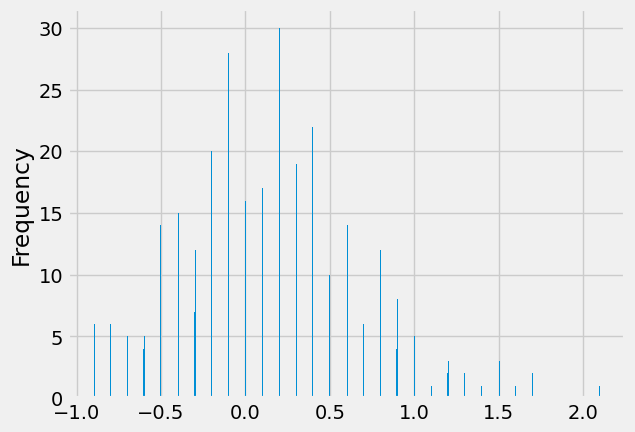

In [167]:
pipe2 =  Pipeline([
    ("6", RemoveOutliers(-1,2.5))       #remove values lower than(...,) and higher than (,...)
])

df = pipe2.fit_transform(df)


### Set Split:

In [168]:
#split = 5; 2 years into future (12 months * 2 years), gap for distance between training and test not sure why necessary
tss = TimeSeriesSplit(n_splits=5, test_size=12*3, gap = 1)

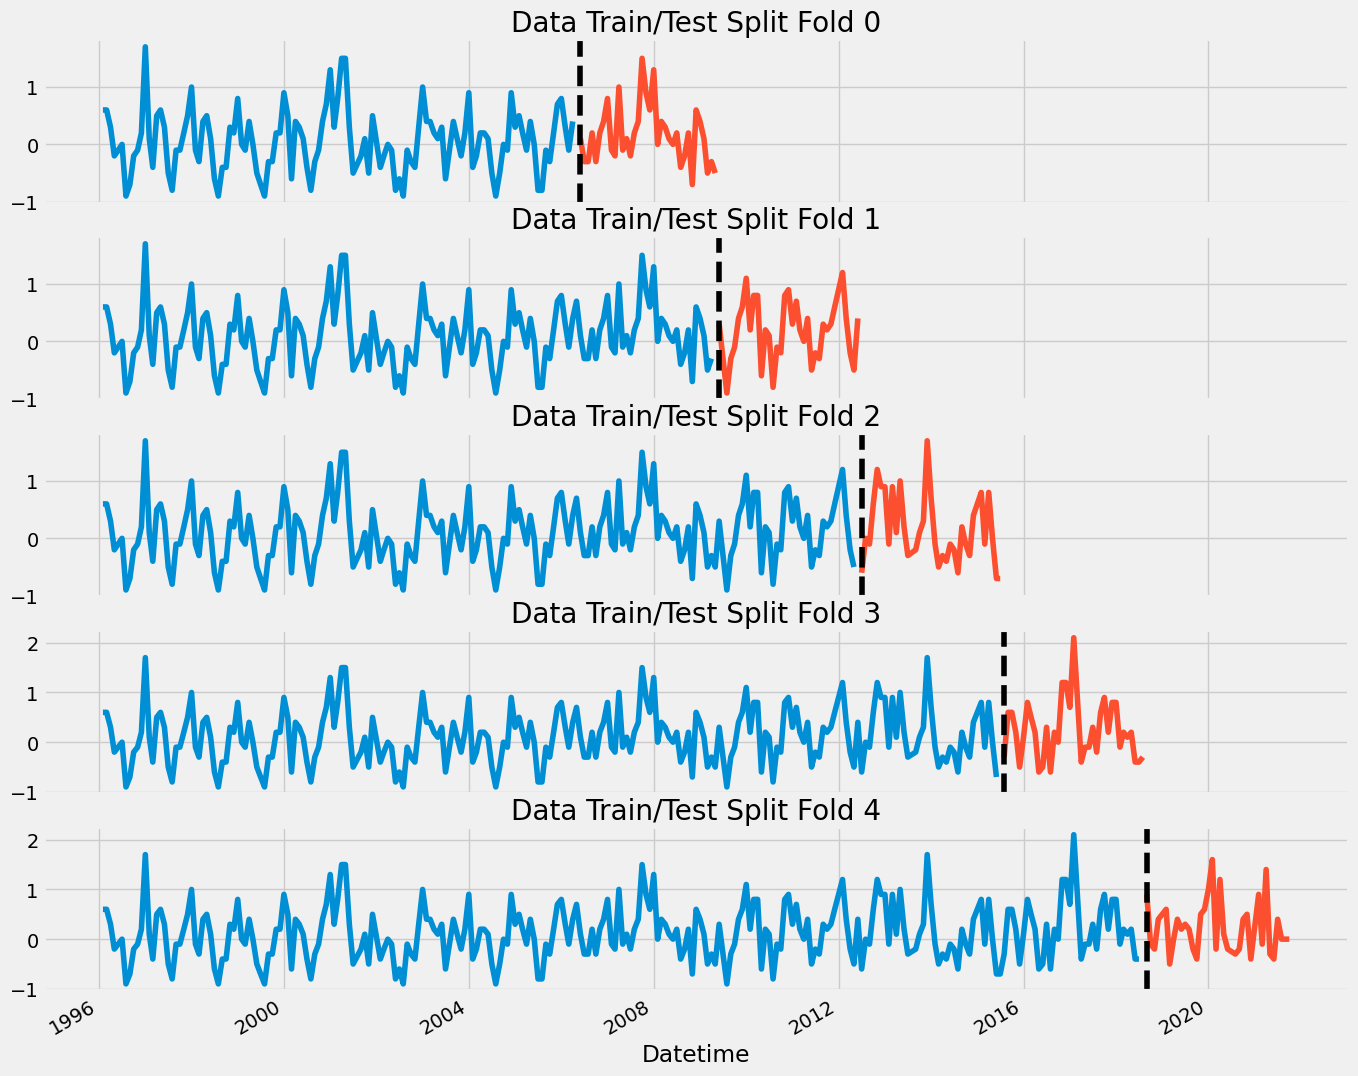

In [169]:
pipe3 =  Pipeline([
    ("7", CrossValidationSplit(tss,show_plot=True)),     #(number of splits, size of splits in years)
    ("8", CreateFeatures())
])

df = pipe3.fit_transform(df)

### do the Training:  

In [183]:
#for debugging (store variable)
df_debug = df

here we could also add options for the other models. Or maybe even use all three models and then compare the results. but that might be a bit too much workd 

            FoodPriceIndex  Month  Year  Quarter
Datetime                                        
1996-02-01             0.6      2  1996        1
1996-03-01             0.6      3  1996        1
1996-04-01             0.3      4  1996        2
1996-05-01            -0.2      5  1996        2
1996-06-01            -0.1      6  1996        2
...                    ...    ...   ...      ...
2005-12-01             0.7     12  2005        4
2006-01-01             0.8      1  2006        1
2006-02-01             0.3      2  2006        1
2006-03-01            -0.1      3  2006        1
2006-04-01             0.4      4  2006        2

[120 rows x 4 columns]
[23:33:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.69420	validation_1-rmse:0.59353


[100]	validation_0-rmse:0.41344	validation_1-rmse:0.45482
[148]	validation_0-rmse:0.36318	validation_1-rmse:0.46314
            FoodPriceIndex  Month  Year  Quarter
Datetime                                        
1996-02-01             0.6      2  1996        1
1996-03-01             0.6      3  1996        1
1996-04-01             0.3      4  1996        2
1996-05-01            -0.2      5  1996        2
1996-06-01            -0.1      6  1996        2
...                    ...    ...   ...      ...
2008-12-01             0.6     12  2008        4
2009-01-01             0.4      1  2009        1
2009-02-01             0.1      2  2009        1
2009-03-01            -0.5      3  2009        1
2009-04-01            -0.3      4  2009        2

[156 rows x 4 columns]
[23:33:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:square

C:\Users\User\AppData\Local\Temp\ipykernel_7412\3504139009.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = reg.predict(X_test)


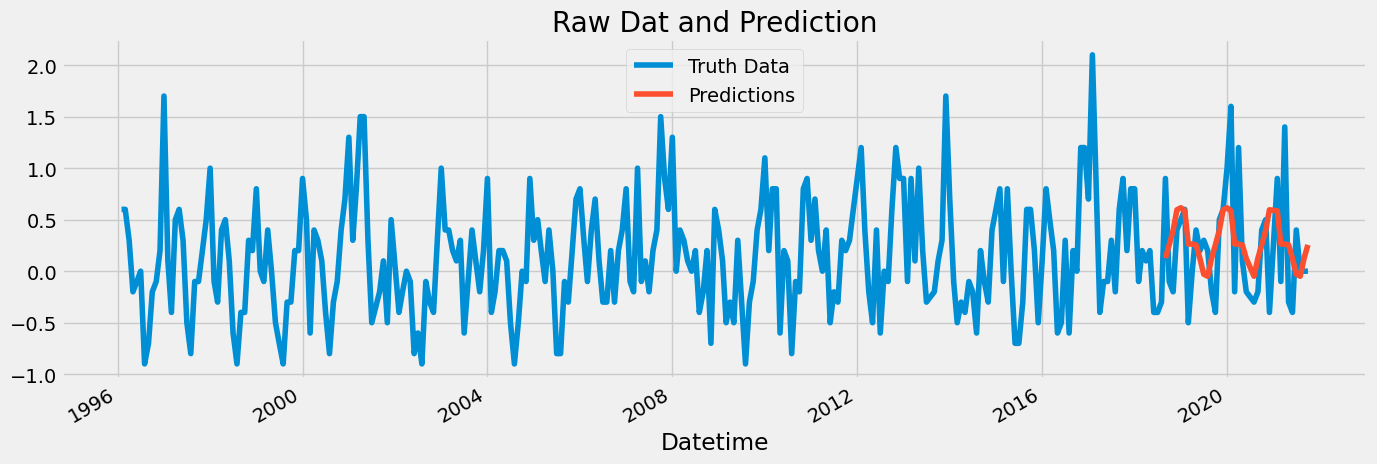

In [184]:
pipe4 = Pipeline([
    ("9", TrainModel(tss,show_plot=True))  #start training including the cross validation and plot (optional)
])

df_debug= pipe4.fit_transform(df_debug)

In [ ]:
df